# INF8775 – Analyse et conception d’algorithmes
# TP3 – Automne 2024

NOM, Prénom, 1234567

NOM, Prénom, 1234567

Note finale:

<u>**Date limite de remise :**</u>  4 décembre 23h59 pour les deux groupes

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- Vous pouvez utiliser des fichiers externes pour stocker des exemplaires et des résultats, mais nous devons être capable de comprendre facilement votre démarche et de la reproduire.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et est une occasion de mettre en application les connaissances vues en cours. Vous devrez développer l'algorithme de votre choix pour essayer de résoudre le plus efficacement possible le problème donné. Une partie de la note sera accordée en fonction des résultats que vous obtiendrez par rapport aux autres équipes.

## Description du problème

Le problème qu'on vous demande de résoudre cette fois-ci est un peu plus difficile. Vous êtes responsable de la séparation des voteurs d'un pays en circonscriptions. Un des deux candidats principaux, M. T, vient vous voir et vous demande de lui garantir une victoire (pour un montant non négligeable d'argent). Évidemment, vous refusez, mais le problème est intéressant et vous décidez d'essayez de le résoudre. Si ça vous intéresse, ce problème est ce qu'on appelle du *gerrymandering*.

Vous aurez comme entrée à votre problème une carte du pays (représentée par une matrice carrée $n \times n$) qui contient à chaque position le nombre de voteurs pour candidat X (un chiffre entre 0 et 1000). Votre objectif est de créer $n$ circonscriptions de sorte à ce que candidat X gagne l'élection. Quelques spécifications importantes:

- La variable $n$ représente un côté de la matrice. Il y a donc, $n^2$ villes.
- Chaque position de la matrice représente une ville
- Chaque circonscription doit contenir **$n$ villes**. Une solution reste valide si une circonscription ne contient pas exactement $n$ villes, mais il y a une **pénalité** qui y est associée.
- Les villes d'une circonscription doivent être proche les unes des autres. On aimerait garder cette **distance à, au plus, $n/2$**. Encore une fois, on permet de briser cette contrainte, mais il y aura une pénalité qui y est associée. (**Distance manhattan**)
- Les villes d'une circonscription ne doivent **pas être nécessairement voisines** tant qu'on respecte la distance maximale. Voir l'exemple plus bas.
- Le candidat remporte une circonscription si le nombre de voteurs dans cette circonscription est supérieur à $500n$.
- Le candidat cherche à remporter le plus de circonscriptions qu'il peut.

![alt text](distance_example.png)


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une matrice carrée de taille $n$ contenant des nombres entre $1$ et $1000$. Vous pouvez utilisez des exemplaires aléatoires pour tester votre code. La compétition sera faite sur les mêmes exemplaires de tailles différentes pour toutes les équipes d'un même groupe.

In [1]:
import random
from collections.abc import Iterable

def generate_city() -> int:
    return round(min(1000,max(0,random.normalvariate(450,200))))

class Problem():
    def __init__(self, size: int, num_samples: int = 5) -> None:
        self.size = size
        self.num_samples = num_samples

    def generate_sample(self) -> list[list[int]]:
        """Returns a matrix containing values between 0 and 1000. Each value is the number of voters in a given city"""
        return [[generate_city() for _ in range(self.size)] for _ in range(self.size)]

    def generate_dataset(self) -> Iterable[list[list[int]]]:
        """Returns an iterator over as many samples as are described"""
        return (self.generate_sample() for _ in range(self.num_samples))

### Création des différent exemplaires pour tester.

In [2]:
size = 5
num_samples = 3
problem = Problem(size, num_samples)

# Générer un échantillon unique
sample = problem.generate_sample()
print("Exemple d'une matrice de votes (taille 5x5) :")
for row in sample:
    print(row)

# Générer un dataset complet
dataset = problem.generate_dataset()
print("\nDataset complet :")
for i, matrix in enumerate(dataset, 1):
    print(f"Exemple {i}:")
    for row in matrix:
        print(row)
    print()


Exemple d'une matrice de votes (taille 5x5) :
[268, 606, 778, 587, 174]
[457, 340, 526, 837, 494]
[231, 527, 411, 230, 646]
[385, 467, 560, 413, 525]
[387, 392, 708, 596, 0]

Dataset complet :
Exemple 1:
[164, 696, 384, 62, 453]
[459, 481, 366, 358, 580]
[895, 144, 689, 841, 713]
[549, 714, 284, 645, 486]
[283, 306, 85, 353, 659]

Exemple 2:
[483, 78, 409, 407, 625]
[408, 605, 347, 757, 732]
[183, 708, 478, 583, 437]
[431, 517, 413, 641, 727]
[776, 480, 580, 368, 258]

Exemple 3:
[574, 554, 478, 429, 463]
[366, 309, 419, 213, 698]
[532, 585, 292, 485, 645]
[498, 655, 476, 426, 814]
[667, 130, 175, 599, 453]



# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [3]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import ceil
from scipy.stats import linregress

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score:int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def score_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Returns the score of the current solution. The score function is a penalty that must be minimized."""
    return votes_score(original, solution) + size_score(solution) + distance_score(solution)

def votes_score(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to lost districts. 
    It is 5 times the square of the number of lost districts."""
    lost_districts = 0
    for district in solution:
        sum = 0
        for city in district:
            sum += original[city[0]][city[1]]
        if sum <= 500*len(district):
            lost_districts += 1
    return 5 * lost_districts**2

def size_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to districts having the wrong size.
    It is the square of the difference between the wanted number of cities and the 
    current number of cities in a given district."""
    n = len(solution)
    size_penality = 0
    for district in solution:
        size_penality += (len(district)-n)**2
    return size_penality

def distance_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to the distance between cities in a district.
    It is the mean square distance between each city and every other city in its district."""
    distance_score = 0
    n = len(solution)
    for district in solution:
        for i,city in enumerate(district):
            for j in range(i+1, len(district)):
                distance_score += (max(0, distance_manhattan(city, district[j])-ceil(n/2)))**2
    return distance_score/len(solution)

def distance_manhattan(city_a: tuple[int,int], city_b: tuple[int,int]) -> int:
    return abs(city_a[0] - city_b[0]) + abs(city_a[1] - city_b[1])

def is_valid_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> bool:
    """Validates solution"""
    n = len(original)

    if len(solution) != n:
        print(f"The solution does not contain {n} districts.")
        return False

    for district in solution:
        if len(district) < 1:
            print("The solution contains empty districts.")
            return False
        for city in district:
            if len(city)!=2:
                print("Solution must contain 2 coordinates per city.")
                return False
            for coord in city:
                if coord < 0 or coord >=n:
                    print(f"City coordinates must below {n} and positive.")
                    return False

    coord_set = set()
    for district in solution:
        for city in district:
            if city in coord_set:
                print(f"City {city} appears in more than one district.")
                return False
            coord_set.add(city)
    if len(coord_set) != n*n:
        print(f"Solution contained {len(coord_set)} different cities while there should be {n*n} cities in the solution.")
        return False

    # Solution is valid
    return True

def make_problems(sizes: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    return [Problem(size,num_samples) for size in sizes]

def measure(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], sample: list[list[int]], time_scale: int = 1000) -> tuple[int,int]:
    """Returns a tuple containing the time as well as the score of the solution, in that order.
    
    Parameters:
        time_scale: Controls the level of precision of the time measurements.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return (round(end - start), score_solution(sample, solution))

def measure_mean(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns a Measure 
    instance representing the result as well as the problem.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results = [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    mean_time = sum(result[0] for result in results) / prob.num_samples
    mean_score = sum(result[1] for result in results) / prob.num_samples
    return Measure(prob.size, mean_time, mean_score)

def measure_range(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken for each problem in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time and the score.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.mean, measure.mean_score))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())

    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)

    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

# Algorithme

Votre algorithme sera en partie noté en fonction d'une évaluation relative entre les équipes. 4 points seront donnés aux équipes qui se classeront dans le premier quartile lors de notre évaluation sur un ensemble d'exemplaires. Les équipes se trouvant dans le quartile dont les algorithmes ont le moins bien performé recevront 1 point.

**IMPORTANT** Votre algo doit retourner une solution après 3 minutes. Si ce n'est pas le cas, vous serez pénalisé.

## Glouton améliorée

In [4]:
def fast_quality_greedy(matrix: list[list[int]]) -> list[list[tuple[int, int]]]:
    n = len(matrix)  # Matrix size
    cities = [(i, j) for i in range(n) for j in range(n)]  # All city coordinates
    districts = []  # Final districts
    assigned = set()  # Set of already assigned cities

    # Precompute vote priorities
    priority_matrix = [[matrix[i][j] for j in range(n)] for i in range(n)]

    # Manhattan distance
    def manhattan(city_a, city_b):
        return abs(city_a[0] - city_b[0]) + abs(city_a[1] - city_b[1])

    # Heuristic function (fast and simple)
    def heuristic(city, center):
        votes = priority_matrix[city[0]][city[1]]
        dist_penalty = 0 if center is None else manhattan(city, center)
        return votes - dist_penalty

    # District formation
    while len(districts) < n:
        # Find the highest-priority unassigned city (seed)
        seed = max(
            [city for city in cities if city not in assigned],
            key=lambda city: priority_matrix[city[0]][city[1]],
        )

        district = [seed]
        assigned.add(seed)
        center = seed  # Initial center is the seed

        while len(district) < n:
            # Get all unassigned cities
            unassigned_cities = [city for city in cities if city not in assigned]
            if not unassigned_cities:
                break

            # Choose the next city based on the heuristic
            next_city = max(unassigned_cities, key=lambda city: heuristic(city, center))
            district.append(next_city)
            assigned.add(next_city)

            # Update center dynamically
            center_x = sum(c[0] for c in district) / len(district)
            center_y = sum(c[1] for c in district) / len(district)
            center = (round(center_x), round(center_y))

        districts.append(district)

    return districts


## Code de base utile

In [14]:
def greedy_search(matrix: list[list[int]]) -> list[list[tuple[int, int]]]:
    n = len(matrix) # Un côté de la matrice
    cities = [(i, j) for i in range(n) for j in range(n)] # Tout les positions dans la matrice
    districts = [] # Résultat
    assigned = set()

    while len(districts) < n: # Pour tout les circonscriptions
        district = []
        while len(district) < n: # Pour la circonscription actuelle
            unassigned_cities = [city for city in cities if city not in assigned]
            if not unassigned_cities: # Aucune ville non assignée
                break

            candidate = max(unassigned_cities, key=lambda city: matrix[city[0]][city[1]])
            district.append(candidate)
            assigned.add(candidate)

        districts.append(district)

    for district in districts:
        while len(district) > n:
            excess_city = min(district, key=lambda city: matrix[city[0]][city[1]])
            district.remove(excess_city)
            assigned.remove(excess_city)

    return districts

def random_search(matrix: list[list[int]]) -> list[list[tuple[int, int]]]:
    n = len(matrix)
    cities = [(i, j) for i in range(n) for j in range(n)]
    random.shuffle(cities)
    districts = [cities[i * n:(i + 1) * n] for i in range(n)]
    return districts

def swap_cities(solution, district1, district2, city1, city2):
    new_solution = [district[:] for district in solution]
    new_solution[district1].remove(city1)
    new_solution[district2].remove(city2)
    new_solution[district1].append(city2)
    new_solution[district2].append(city1)
    return new_solution


def local_search(matrix, time_limit, start_time):
    n = len(matrix)
    current_solution = fast_quality_greedy(matrix)
    current_score = score_solution(matrix, current_solution)
    
    improved = True

    while improved and time.time() - start_time < time_limit:
        improved = False
        for district1 in range(n):
            for district2 in range(n):
                if district1 != district2:


                    for city1 in current_solution[district1]:
                        for city2 in current_solution[district2]:
                            if time.time() - start_time >= time_limit:
                                return current_solution
                            new_solution = swap_cities(current_solution, district1, district2, city1, city2)
                            new_score = score_solution(matrix, new_solution)
                            
                            if new_score < current_score:
                                current_solution = new_solution
                                current_score = new_score
                                improved = True
                                break
                        if improved:
                            break
                if improved:
                    break
    return current_solution


## Recherche locale améliorée

In [ ]:


def mutilple_local_search(matrix):
    max_time=60/200
    start_time = time.time()
    best_solution = fast_quality_greedy(matrix)
    best_score = score_solution(matrix, best_solution)
    
    while time.time() - start_time < max_time:
        rand_solution = random_search(matrix)
        rand_score = score_solution(matrix, rand_solution)
        new_solution = local_search_upgraded(matrix, rand_solution, rand_score, start_time, max_time)
        new_score = score_solution(matrix, new_solution)
        if new_score < best_score:
            best_solution = new_solution
            best_score = new_score
    return best_solution

def local_search_upgraded(matrix, solution, score, start_time, max_time):
    n = len(matrix)
    best_solution = solution
    best_score = score
    current_solution = solution
    current_score = score
    improved = True
    while improved and time.time() - start_time < max_time:
        improved = False

        for district1 in range(n):
            for district2 in range(n):
                if district1 != district2:
                    for city1 in current_solution[district1]:
                        for city2 in current_solution[district2]:
                            if time.time() - start_time >= max_time:
                                return best_solution
                            new_solution = swap_cities(current_solution, district1, district2, city1, city2)
                            new_score = score_solution(matrix, current_solution)
                            if new_score < current_score:
                                current_solution = new_solution
                                current_score = new_score
                                improved = True
                                if new_score < best_score:
                                    best_solution = current_solution
                                    best_score = new_score
                if improved:
                    break
            if improved:
                break
    return best_solution


## Recherche local avec recuit simulé

In [15]:
import math
import random
import time

def simulated_annealing(matrix, initial_temp=1000, cooling_rate=0.995, time_limit=180):
    start_time = time.time()
    def generate_neighbor(solution):
        n = len(solution)
        district1, district2 = random.sample(range(n), 2)
        if solution[district1] and solution[district2]:
            city1 = random.choice(solution[district1])
            city2 = random.choice(solution[district2])
            return swap_cities(solution, district1, district2, city1, city2)
        return solution

    def acceptance_probability(current_score, new_score, temperature):
        if new_score < current_score:
            return 1.0
        return math.exp((current_score - new_score) / temperature)

    current_solution = local_search(matrix, time_limit, start_time)
    current_score = score_solution(matrix, current_solution)
    best_solution = current_solution
    best_score = current_score

    temperature = initial_temp

    while temperature > 1:
        if time.time() - start_time > time_limit:
            return best_solution
        new_solution = generate_neighbor(current_solution)
        new_score = score_solution(matrix, new_solution)
        if random.random() < acceptance_probability(current_score, new_score, temperature):
            current_solution = new_solution
            current_score = new_score
            if new_score < best_score:
                best_solution = new_solution
                best_score = new_score
        temperature *= cooling_rate
    return best_solution


## Recherche local avec recherche à voisinage variable

In [7]:
def variable_neighborhood_search(matrix, max_iterations=500, neighborhood_depth=3):
    def generate_neighborhood(solution, depth):
        neighbors = []
        n = len(solution)
        for _ in range(depth):
            district1, district2 = random.sample(range(n), 2)
            if solution[district1] and solution[district2]:
                city1 = random.choice(solution[district1])
                city2 = random.choice(solution[district2])
                new_solution = swap_cities(solution, district1, district2, city1, city2)
                neighbors.append(new_solution)
        return neighbors

    n = len(matrix)
    current_solution = local_search(matrix)
    current_score = score_solution(matrix, current_solution)

    iteration = 0
    while iteration < max_iterations:
        improved = False
        for depth in range(1, neighborhood_depth + 1):
            neighbors = generate_neighborhood(current_solution, depth)

            for neighbor in neighbors:
                neighbor_score = score_solution(matrix, neighbor)

                if neighbor_score < current_score:
                    current_solution = neighbor
                    current_score = neighbor_score
                    improved = True
                    break
            if improved:
                break

        iteration += 1

    return current_solution

## Pour visualiser

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_districts(matrix, districts):
    n = len(matrix)
    grid = np.zeros((n, n), dtype=int)
    for district_id, district in enumerate(districts, start=1):
        for x, y in district:
            grid[x, y] = district_id
    plt.imshow(grid, cmap="tab20", interpolation="nearest")

    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{matrix[i][j]}", ha="center", va="center", color="white", fontsize=8)
    plt.show()



## Résultat

In [20]:
size = 10
num_samples = 10
problem = Problem(size, num_samples)

#result_variable_neighborhood_search = measure_mean(variable_neighborhood_search, problem)
#result_local_search = measure_mean(local_search, problem)
result_simulated_annealing = measure_mean(simulated_annealing, problem)
#result_m_local_search= measure_mean(mutilple_local_search, problem) #1minute

#print("Variable Neighborhood Search:")
#print(f"Temps moyen: {result_variable_neighborhood_search.mean}")
#print(f"Score moyen: {result_variable_neighborhood_search.mean_score}")

#print("\nLocal Search:")
#print(f"Temps moyen: {result_local_search.mean}")
#print(f"Score moyen: {result_local_search.mean_score}")

print("\nSimulated Annealing:")
print(f"Temps moyen: {result_simulated_annealing.mean}")
print(f"Score moyen: {result_simulated_annealing.mean_score}")

#print("\nLocal upgraded Search:")                                        Bad score
#print(f"Temps moyen: {result_m_local_search.mean}")
#print(f"Score moyen: {result_m_local_search.mean_score}")






Simulated Annealing:
Temps moyen: 87400.0
Score moyen: 57.910000000000004


# Comparaison des différents algo

Variable Neighborhood Search 51.81366666666667
Local Search 50.462500000000006
Simulated Annealing 45.82483333333334


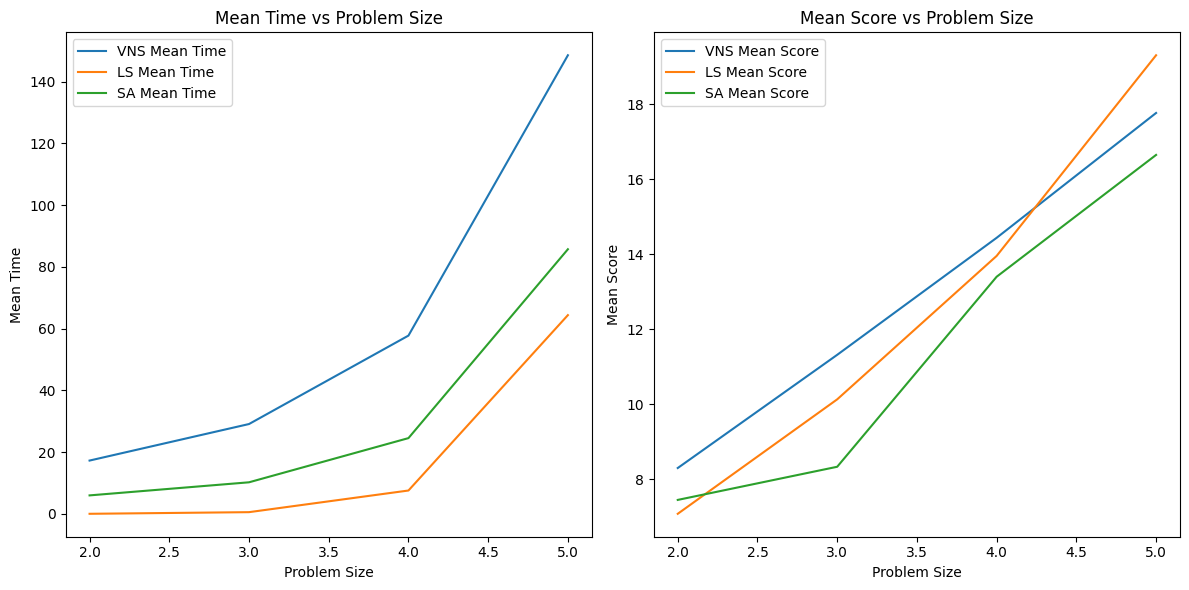

Variable Neighborhood Search 100.30766666666666
Local Search 97.919
Simulated Annealing 91.72416666666668


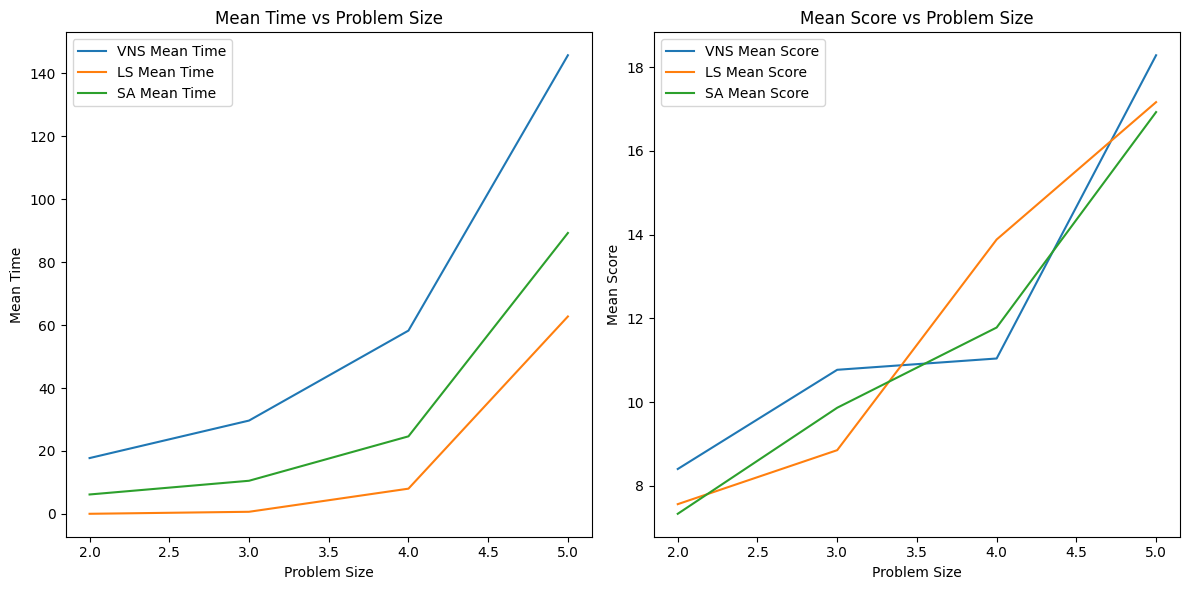

Variable Neighborhood Search 149.66833333333332
Local Search 146.09483333333333
Simulated Annealing 139.93866666666668


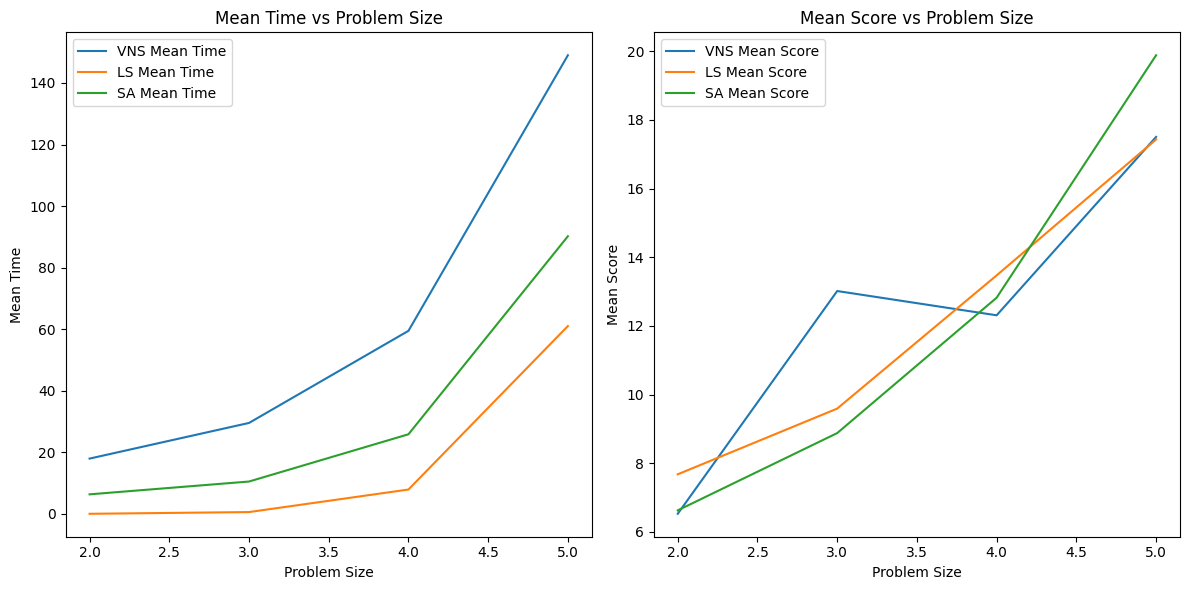

Variable Neighborhood Search 196.19133333333332
Local Search 194.3575
Simulated Annealing 187.24366666666668


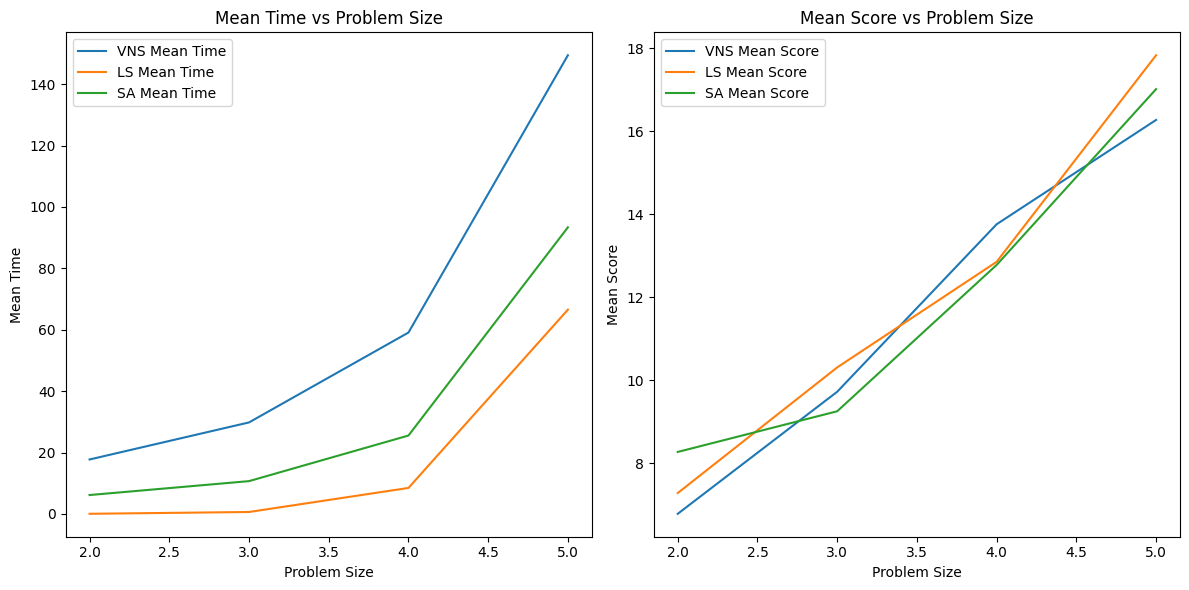

4


In [11]:
sizes = range(7, 9)  # Adjust the range as needed
results = {"Variable Neighborhood Search": [], "Local Search": [], "Simulated Annealing": []}
tries =0
Test=0
Test2=0
Test3=0
# Collect results for each size
for i in range(1,5):
    sizes = range(2, 6)  # Adjust the range as needed
    results = {"Variable Neighborhood Search": [], "Local Search": [], "Simulated Annealing": []}
    tries +=1
    for size in sizes:
        problem = Problem(size, num_samples=100)
        results["Variable Neighborhood Search"].append(measure_mean(variable_neighborhood_search, problem))
        results["Local Search"].append(measure_mean(local_search, problem))
        results["Simulated Annealing"].append(measure_mean(simulated_annealing, problem))

    # Extract mean times and mean scores for each algorithm
    vns_means = [res.mean for res in results["Variable Neighborhood Search"]]
    vns_scores = [res.mean_score for res in results["Variable Neighborhood Search"]]
    ls_means = [res.mean for res in results["Local Search"]]
    ls_scores = [res.mean_score for res in results["Local Search"]]
    sa_means = [res.mean for res in results["Simulated Annealing"]]
    sa_scores = [res.mean_score for res in results["Simulated Annealing"]]

    for res in results["Variable Neighborhood Search"]:
        Test+= res.mean_score

    for res in results["Local Search"]:
        Test2+= res.mean_score

    for res in results["Simulated Annealing"]:
        Test3+= res.mean_score

    print("Variable Neighborhood Search", Test)
    print("Local Search", Test2)
    print("Simulated Annealing", Test3)

    # Plotting code (adapt to your needs)
    plt.figure(figsize=(12, 6))

    # Plot mean times
    plt.subplot(1, 2, 1)
    plt.plot(sizes, vns_means, label="VNS Mean Time")
    plt.plot(sizes, ls_means, label="LS Mean Time")
    plt.plot(sizes, sa_means, label="SA Mean Time")
    plt.title("Mean Time vs Problem Size")
    plt.xlabel("Problem Size")
    plt.ylabel("Mean Time")
    plt.legend()

    # Plot mean scores
    plt.subplot(1, 2, 2)
    plt.plot(sizes, vns_scores, label="VNS Mean Score")
    plt.plot(sizes, ls_scores, label="LS Mean Score")
    plt.plot(sizes, sa_scores, label="SA Mean Score")
    plt.title("Mean Score vs Problem Size")
    plt.xlabel("Problem Size")
    plt.ylabel("Mean Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

print(tries)

# Analyse asymptotique

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Greedy_search:

- n = len(matrix) : opération élémentaire, complexité temporelle et spatiale de O(1)

- cities = [(i, j) for i in range(n) for j in range(n)] :
  - Création d'une liste contenant les coordonnées de toutes les villes dans la matrice.
  - Complexité temporelle : O(n²) (parcours de chaque cellule de la matrice).
  - Complexité spatiale : O(n²) (allocation d'une liste contenant n² éléments).

- districts = [] :
  - Initialisation d'une liste vide pour stocker les districts.
  - Complexité temporelle : O(1).
  - Complexité spatiale : O(1).

- assigned = set() :
  - Initialisation d'un ensemble vide pour suivre les villes assignées.
  - Complexité temporelle : O(1).
  - Complexité spatiale : O(1).

- while len(districts) < n : boucle principale
  - Cette boucle s'exécute n fois (une fois par district).
  - Complexité temporelle totale : dépend des opérations à l'intérieur (voir ci-dessous).

  - district = [] :
    - Initialisation d'une liste vide pour contenir les villes d'un district.
    - Complexité temporelle : O(1).
    - Complexité spatiale : O(1).

  - while len(district) < n : boucle secondaire
    - Cette boucle s'exécute au maximum n fois pour remplir un district avec n villes.
    - Complexité temporelle totale : dépend des opérations internes.

    - unassigned_cities = [city for city in cities if city not in assigned] :
      - Création d'une liste des villes non assignées.
      - Complexité temporelle : O(n²) (parcours de toutes les villes).
      - Complexité spatiale : O(n²) (allocation d'une liste temporaire).

    - candidate = max(unassigned_cities, key=lambda city: matrix[city[0]][city[1]]) :
      - Recherche de la ville avec le maximum de votes parmi les villes non assignées.
      - Complexité temporelle : O(n²) (parcours de la liste unassigned_cities).
      - Complexité spatiale : O(1).

    - district.append(candidate) :
      - Ajout d'une ville à la liste du district.
      - Complexité temporelle : O(1).
      - Complexité spatiale : O(1).

    - assigned.add(candidate) :
      - Ajout de la ville assignée dans l'ensemble `assigned`.
      - Complexité temporelle : O(1).
      - Complexité spatiale : O(1).

  - districts.append(district) :
    - Ajout d'un district complet à la liste `districts`.
    - Complexité temporelle : O(1).
    - Complexité spatiale : O(1).

Complexité Totale pour Greedy Search :
- Complexité temporelle : O(n³)
  - Explication : Boucle extérieure (n) × boucle intérieure (n) × opérations internes (O(n²)).
- Complexité spatiale : O(n²)
  - Explication : Stockage de la liste `districts` et de la liste `cities`, chacun de taille O(n²).

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Random Search

- n = len(matrix) : opération élémentaire, complexité temporelle et spatiale de O(1)

- cities = [(i, j) for i in range(n) for j in range(n)] :
  - Création d'une liste contenant les coordonnées de toutes les villes.
  - Complexité temporelle : O(n²).
  - Complexité spatiale : O(n²).

- random.shuffle(cities) :
  - Mélange aléatoire des éléments dans la liste `cities`.
  - Complexité temporelle : O(n²).
  - Complexité spatiale : O(1).

- districts = [cities[i * n:(i + 1) * n] for i in range(n)] :
  - Découpage de la liste `cities` mélangée en n districts de taille n.
  - Complexité temporelle : O(n²) (création de sous-listes).
  - Complexité spatiale : O(n²) (allocation pour les districts).

Complexité Totale pour Random Search :
- Complexité temporelle : O(n²).
- Complexité spatiale : O(n²).

Complexité Totale pour Random Search :
- Complexité temporelle : O(n²)
  - Explication : La génération de toutes les villes O(n²), suivie d'un mélange aléatoire O(n²). La division en districts est une opération linéaire O(n), dominée par O(n²).
- Complexité spatiale : O(n²)
  - Explication : Stockage des coordonnées des villes dans `cities` et `districts`, chacun de taille O(n²).

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Local Search

- n = len(matrix) opération élémentaire pour déterminer la taille de la matrice.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

- current_solution = greedy_search(matrix) génère une solution initiale à l’aide de l’algorithme glouton.
  - Complexité temporelle : O(n^3) (provenant de greedy_search).
  - Complexité spatiale : O(n^2) (solution générée).

- current_score = score_solution(matrix, current_solution) calcule le score initial de la solution.
  - Complexité temporelle : O(n^3) (score pour n districts de taille n).
  - Complexité spatiale : O(1) (aucune structure supplémentaire).

- improved = True initialise une variable de contrôle.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

- while improved: boucle principale exécutée tant qu’il y a des améliorations possibles.
  - Complexité temporelle : dépend du nombre d’itérations, noté k (améliorations successives).
  - Complexité spatiale : aucun nouvel espace significatif n’est utilisé.

  - improved = False réinitialise la variable à chaque itération.
    - Complexité temporelle : O(1)
    - Complexité spatiale : O(1)

  - for district1 in range(n): boucle sur tous les districts (n districts).
    - Complexité temporelle : O(n)

    - for district2 in range(n): boucle imbriquée pour comparer chaque district avec les autres.
      - Complexité temporelle : O(n)
      
      - if district1 != district2: condition pour éviter la comparaison d’un district avec lui-même.
        - Complexité temporelle : O(1)

      - for city1 in current_solution[district1]: boucle sur les villes du district1 (n villes par district).
        - Complexité temporelle : O(n)

        - for city2 in current_solution[district2]: boucle imbriquée sur les villes du district2.
          - Complexité temporelle : O(n)
          - Complexité cumulée des boucles : O(n^4)

          - new_solution = swap_cities(current_solution, district1, district2, city1, city2) crée une nouvelle solution en échangeant deux villes.
            - Complexité temporelle : O(n^2) (copie de la solution).
            - Complexité spatiale : O(n^2) (nouvelle solution temporaire).

          - new_score = score_solution(matrix, new_solution) calcule le score de la nouvelle solution.
            - Complexité temporelle : O(n^3) (évaluation du score).
            - Complexité spatiale : O(1)

          - if new_score < current_score: vérifie si la nouvelle solution est meilleure.
            - Complexité temporelle : O(1)
          
          - current_solution = new_solution met à jour la solution courante si elle est meilleure.
            - Complexité temporelle : O(1)
            - Complexité spatiale : O(1)

          - current_score = new_score met à jour le score de la solution.
            - Complexité temporelle : O(1)
            - Complexité spatiale : O(1)

          - improved = True marque qu’une amélioration a été trouvée.
            - Complexité temporelle : O(1)
            - Complexité spatiale : O(1)

- return current_solution retourne la meilleure solution trouvée.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

Complexité Totale pour Local Search :
- Complexité temporelle : O(n³)
  - Explication : 
    - Boucle extérieure sur les districts (O(n)).
    - Deux boucles imbriquées pour comparer les villes entre districts (O(n²)).
    - Calcul des scores (O(n)) pour chaque tentative d'amélioration.
    - Total : O(n × n² × n) = O(n³).
- Complexité spatiale : O(n²)
  - Explication : Stockage des districts, chacun contenant O(n²) villes au total.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Exhaustive Search

- n = len(matrix) opération élémentaire pour déterminer la taille de la matrice.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

- cities = [(i, j) for i in range(n) for j in range(n)] génère une liste de toutes les coordonnées des villes.
  - Complexité temporelle : O(n^2) (construction d’une liste de n^2 éléments).
  - Complexité spatiale : O(n^2) (stockage des coordonnées).

- best_score = float('inf') initialise le meilleur score avec une valeur infinie.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

- best_solution = None initialise la meilleure solution comme vide.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

- for permuted_cities in permutations(cities): boucle générant toutes les permutations des villes.
  - Complexité temporelle : O((n^2)!) (génération de toutes les permutations des villes).
  - Complexité spatiale : O(n^2) (chaque permutation nécessite de stocker n^2 éléments).

  - grouped_districts = [list(permuted_cities[i * n:(i + 1) * n]) for i in range(n)] groupe les villes permutées en n districts de taille n.
    - Complexité temporelle : O(n^2) (division des n^2 villes en n groupes).
    - Complexité spatiale : O(n^2) (liste temporaire pour les districts).

  - for permuted_districts in permutations(grouped_districts): génère toutes les permutations des districts.
    - Complexité temporelle : O(n!) (n districts peuvent être ordonnés de n! façons).
    - Complexité spatiale : O(n^2) (chaque permutation nécessite de stocker les districts).

    - internal_permutations = [list(permutations(district)) for district in permuted_districts] génère toutes les permutations internes des districts.
      - Complexité temporelle : O(n × n!) (chaque district de taille n a n! permutations).
      - Complexité spatiale : O(n × n!) (stockage de toutes les permutations internes).

    - for candidate_solution in product(*internal_permutations): génère toutes les combinaisons possibles des permutations internes.
      - Complexité temporelle : O((n!)^n) (produit cartésien des permutations internes).
      - Complexité spatiale : O(n^2) (chaque solution candidate stocke n^2 éléments).

      - current_solution = [list(district) for district in candidate_solution] construit une solution candidate.
        - Complexité temporelle : O(n^2) (copie des districts).
        - Complexité spatiale : O(n^2) (structure temporaire pour la solution).

      - current_score = score_solution(matrix, current_solution) calcule le score de la solution candidate.
        - Complexité temporelle : O(n^3) (évaluation du score pour n districts de taille n).
        - Complexité spatiale : O(1)

      - if current_score < best_score: vérifie si la solution candidate est meilleure.
        - Complexité temporelle : O(1)

      - best_score = current_score met à jour le meilleur score si la solution est meilleure.
        - Complexité temporelle : O(1)
        - Complexité spatiale : O(1)

      - best_solution = current_solution met à jour la meilleure solution.
        - Complexité temporelle : O(1)
        - Complexité spatiale : O(n^2) (stockage de la meilleure solution).

- return best_solution retourne la meilleure solution trouvée.
  - Complexité temporelle : O(1)
  - Complexité spatiale : O(1)

Complexité Totale pour Exhaustive Search :

- Complexité temporelle : O((n²)! × (n!)ⁿ)
  - Explication : 
    - Génération de toutes les permutations de villes (O((n²)!)).
    - Division en districts avec permutations internes (O((n!)ⁿ)).
    - Évaluation des scores pour chaque solution, linéaire par rapport au nombre de permutations.
    - Total : O((n²)! × (n!)ⁿ), impraticable pour n > 3.
- Complexité spatiale : O(n²)
  - Explication : Stockage de la matrice des coordonnées des villes et des districts.






Résultats pour Greedy Search :
Taille       Temps moyen  Score moyen 
1            0.005        3.055       
2            0.006        8.63        
3            0.012        18.685333333333332
4            0.035        40.533      
5            0.075        65.38159999999999

Résultats pour Local Search :
Taille       Temps moyen  Score moyen 
1            0.004        3.07        
2            0.047        7.694       
3            0.62         10.069      
4            8.064        13.48975    
5            62.25        17.6486     


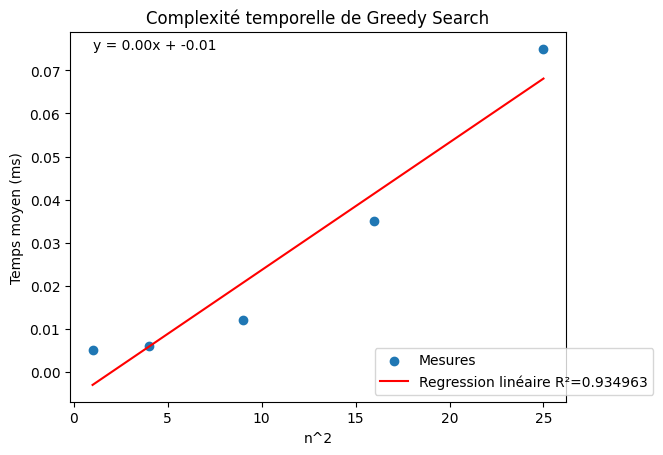

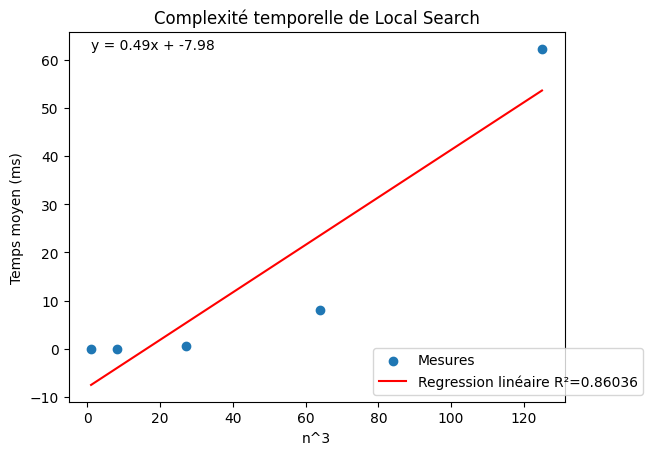

In [12]:
# Analyse hybride

sizes = [1,2,3,4,5,]  # Tailles des matrices
num_samples = 1000  # Nombre d'échantillons par taille
problems = make_problems(sizes, num_samples=num_samples)  # Générer les problèmes

# Mesures pour chaque algorithme
results_greedy = measure_range(greedy_search, problems)
results_local_search = measure_range(local_search, problems)
#results_exhaustive = measure_range(exhaustive_search, problems)

# Affichage des résultats
print("\nRésultats pour Greedy Search :")
display_data_as_table(results_greedy)

print("\nRésultats pour Local Search :")
display_data_as_table(results_local_search)

#print("\nRésultats pour Exhaustive Search :")
#display_data_as_table(results_exhaustive)


import numpy as np

data_greedy = {r.size ** 2: r.mean for r in results_greedy}
data_local = {r.size ** 3: r.mean for r in results_local_search}
#data_exhaustive = {r.size ** 4: r.mean for r in results_exhaustive}  # Approximation pour exhaustive

# Graphique pour Greedy Search
test_de_puissance(
    data=data_greedy,
    x_label="n^2",
    y_label="Temps moyen (ms)",
    title="Complexité temporelle de Greedy Search"
)

# Graphique pour Local Search
test_de_puissance(
    data=data_local,
    x_label="n^3",
    y_label="Temps moyen (ms)",
    title="Complexité temporelle de Local Search"
)

# Graphique pour Exhaustive Search
#test_de_puissance(
    #data=data_exhaustive,
    #x_label="n^4",
    #y_label="Temps moyen (ms)",
    #title="Complexité temporelle de Exhaustive Search"
#)


# Analyse code carbon (2 pts)

Effectuer une anlayse code carbon en sélectionnant différent pays pour l'analyse. Commenter vos résultats.

In [13]:
from codecarbon import EmissionsTracker

# List of countries for comparison
countries = ["USA", "FRA", "CHN", "IND", "NOR"]
results = {}

for country in countries:
    # Create an emissions tracker
    tracker = EmissionsTracker(measure_power_secs=1)
    tracker._geo.country_iso_code = country  # Manually override the country

    tracker.start()
    # Code to analyze (replace with your actual workload)
    for _ in range(10**6):
        pass
    emissions = tracker.stop()
    results[country] = emissions

# Print results
for country, emission in results.items():
    print(f"Country: {country}, Emissions: {emission:.6f} kg CO2")


ModuleNotFoundError: No module named 'codecarbon'

# Conclusion (6 pts)

Faites une synthèse de vos analyses pour mettre en évidence les qualités et défauts de votre algorithme. Mentionnez les améliorations qui vous ont permis d'atteindre votre algorithme actuel ainsi que des pistes d'améliorations potentielles restantes.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.